In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [20]:
tweets = pd.read_csv('Elon_musk.csv',encoding='cp1252')
tweets

,Unnamed: 0,Text
0,1,@kunalb11 I’m an alien
1,2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,3,@joerogan @Spotify Great interview!
3,4,@gtera27 Doge is underestimated
4,5,@teslacn Congratulations Tesla China for amazi...
...,...,...
1994,1995,"@flcnhvy True, it sounds so surreal, but the n..."
1995,1996,@PPathole Make sure to read ur terms &amp; con...
1996,1997,@TeslaGong @PPathole Samwise Gamgee
1997,1998,@PPathole Altho Dumb and Dumber is <U+0001F525...


In [21]:
tweets.drop(['Unnamed: 0'], inplace= True, axis= 1)
tweets

,Text
0,@kunalb11 I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


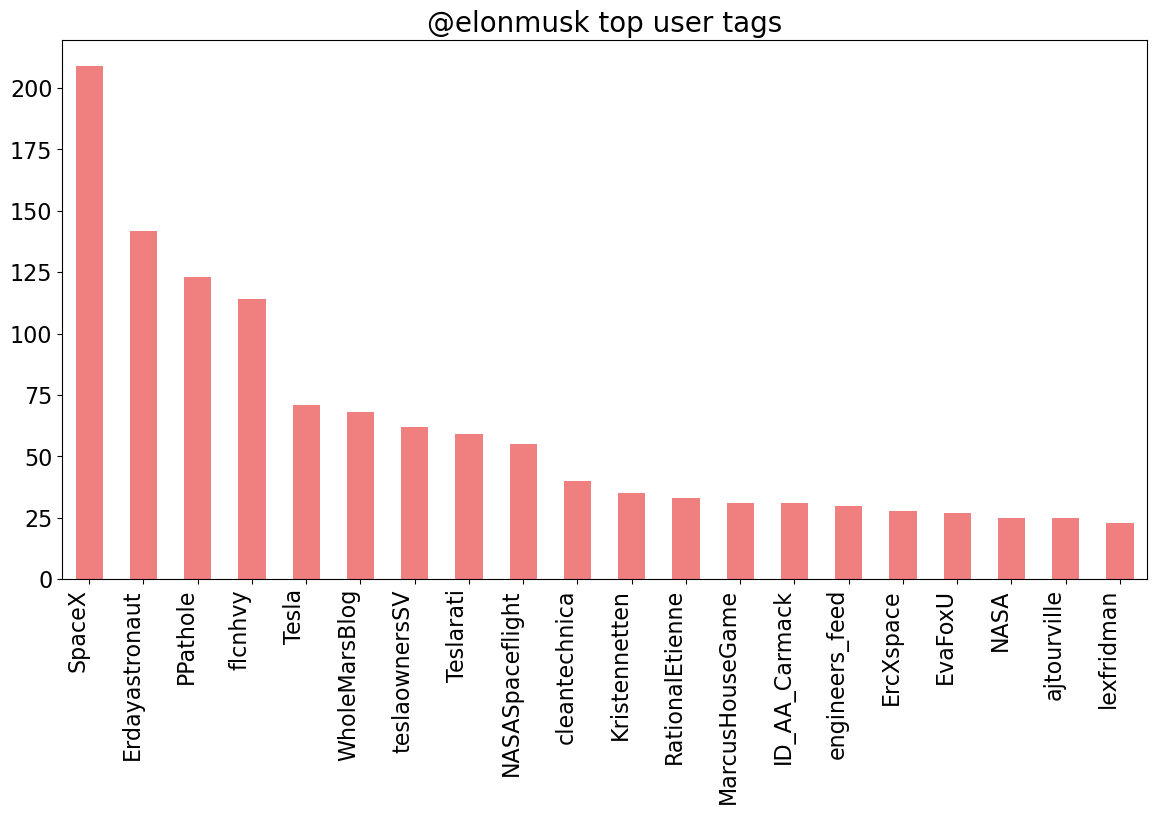

In [22]:
import itertools

c = list(itertools.chain(*tweets.Text.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ")
                                                     if '@' in handle.replace(":", "")]).tolist()))

pd.Series(c).value_counts().head(20).plot.bar(figsize=(14, 7), fontsize=16, color='lightcoral')
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='right', fontsize=16)
pass

In [23]:
import re #regular expression
import string

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("[0-9" "]+"," ",text)
    text = re.sub('[‘’“”…]', '', text)
    return text

clean = lambda x: clean_text(x)

tweets["Text"] = tweets["Text"].apply(clean_text) # Clean The Text
tweets.head(11)

,Text
0,im an alien
1,idaacarmack ray tracing on cyberpunk with hdr ...
2,joerogan spotify great interview
3,doge is underestimated
4,teslacn congratulations tesla china for amazin...
5,happy new year of the ox
6,frodo was the underdoge\nall thought he would ...
7,owensparks flcnhvy haha thanks
8,flcnhvy indeed tweets definitely do not repre...
9,the most entertaining outcome is the most likely


In [24]:
freq = pd.Series(' '.join(tweets['Text']).split()).value_counts()[:20] # for top 20
freq

the               487
to                400
a                 356
is                355
of                315
spacex            239
in                219
amp               218
for               194
tesla             166
will              165
be                157
erdayastronaut    142
this              140
it                138
we                136
on                129
that              128
rt                127
but               126
Name: count, dtype: int64

In [25]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
tweets['Text'] = tweets['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [26]:
freq_stp = pd.Series(' '.join(tweets['Text']).split()).value_counts()[:20] # for top 20
freq_stp

spacex             239
amp                218
tesla              166
erdayastronaut     142
rt                 127
ppathole           123
flcnhvy            114
yes                 86
great               76
teslaownerssv       73
wholemarsblog       68
teslarati           59
nasaspaceflight     55
haha                55
good                51
launch              49
sure                43
yeah                41
cleantechnica       40
would               40
Name: count, dtype: int64

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

# Assuming 'tweets' is your DataFrame containing text data
vectorizer = CountVectorizer(min_df=1, max_df=0.9)
X = vectorizer.fit_transform(tweets["Text"])

# Get feature names using get_feature_names_out() method
feature_names = vectorizer.get_feature_names_out()

# Calculate word frequencies
word_occurrences = np.asarray(X.sum(axis=0)).ravel().tolist()

# Create DataFrame
word_freq_df = pd.DataFrame({'term': feature_names, 'occurrences': word_occurrences})
word_freq_df['frequency'] = word_freq_df['occurrences'] / np.sum(word_freq_df['occurrences'])
word_freq_df.head(11)

,term,occurrences,frequency
0,aber,1,0.000076
1,able,6,0.000453
2,abo,1,0.000076
3,aboard,1,0.000076
4,abort,3,0.000227
5,absence,1,0.000076
6,absolute,1,0.000076
7,absolutely,15,0.001133
8,absorb,1,0.000076
9,absorption,1,0.000076


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.5, smooth_idf=True)
doc_vec = vectorizer.fit_transform(tweets["Text"])
feature_names = vectorizer.get_feature_names_out()
dense = doc_vec.todense()
denselist = dense.tolist()


In [44]:
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(corpus) #for tri-gram, put ngram_range=(3,3)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [45]:
top2_words = get_top_n2_words(tweets["Text"], n=200) #top 200
top2_df = pd.DataFrame(top2_words)
top2_df.columns = ["Bi-gram", "Freq"]
top2_df.head(11)

,Bi-gram,Freq
0,rt spacex,71
1,spacex falcon,17
2,erdayastronaut spacex,16
3,pretty much,12
4,rt nasa,12
5,waemd spacex,11
6,giga berlin,10
7,first stage,10
8,teslaratiteam teslarati,10
9,nasa spacex,9


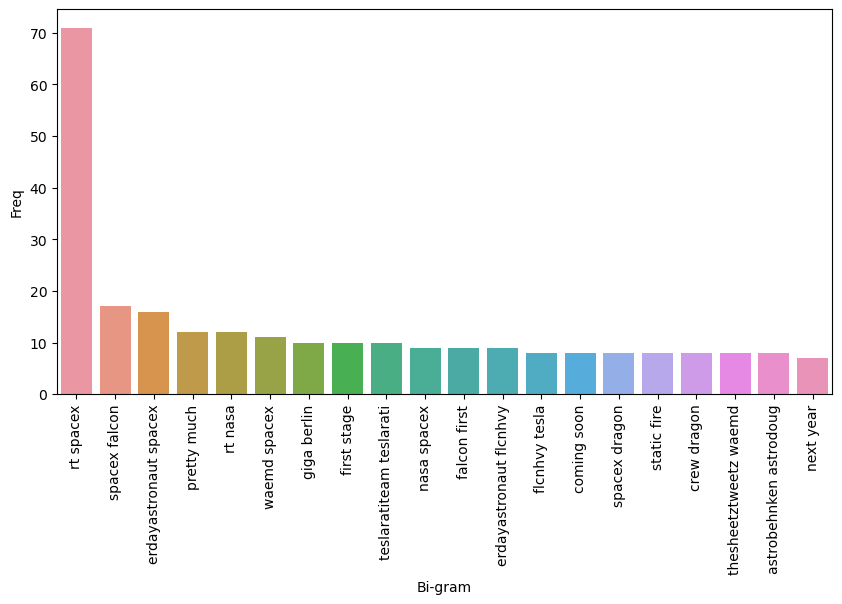

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
top20_bigram = top2_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot = sns.barplot(x=top20_bigram["Bi-gram"],y=top20_bigram["Freq"])
plot.set_xticklabels(rotation=90,labels = top20_bigram["Bi-gram"]);

In [47]:
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [48]:
top3_words = get_top_n3_words(tweets["Text"], n=200)
top3_df = pd.DataFrame(top3_words)
top3_df.columns = ["Tri-gram", "Freq"]
top3_df.head(11)

,Tri-gram,Freq
0,rt spacex falcon,17
1,falcon first stage,9
2,spacex falcon first,8
3,thesheetztweetz waemd spacex,8
4,course still love,7
5,ppathole thesheetztweetz waemd,7
6,waemd spacex spacexstarlink,7
7,first stage landed,6
8,rt spacex liftoff,6
9,spacex spacexstarlink wanationalguard,6


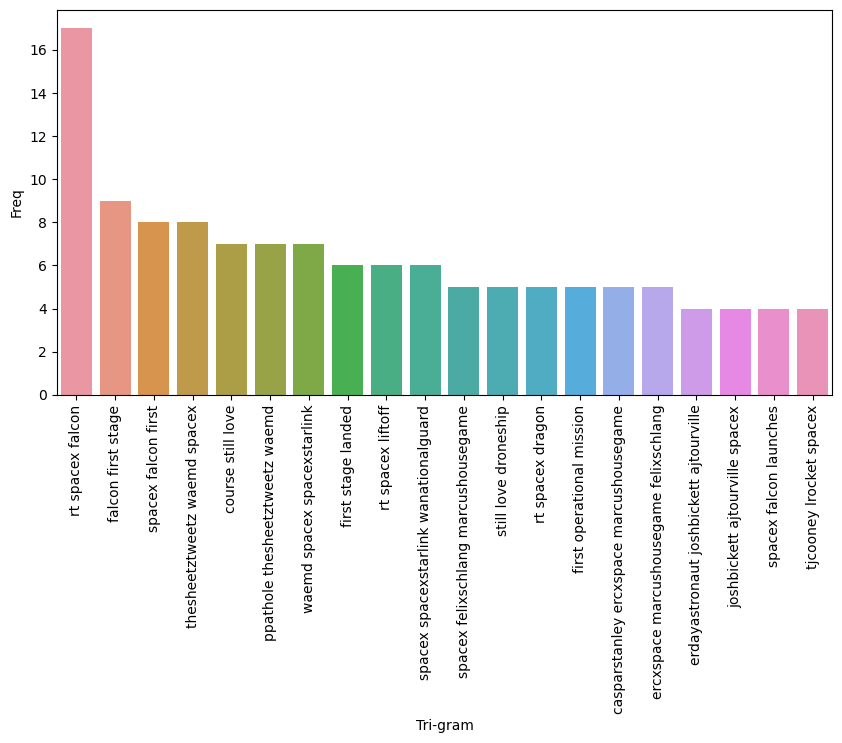

In [49]:
import seaborn as sns
top20_trigram = top3_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot = sns.barplot(x=top20_trigram["Tri-gram"],y=top20_trigram["Freq"])
plot.set_xticklabels(rotation=90,labels = top20_trigram["Tri-gram"]);

In [50]:
string_Total = " ".join(tweets["Text"])

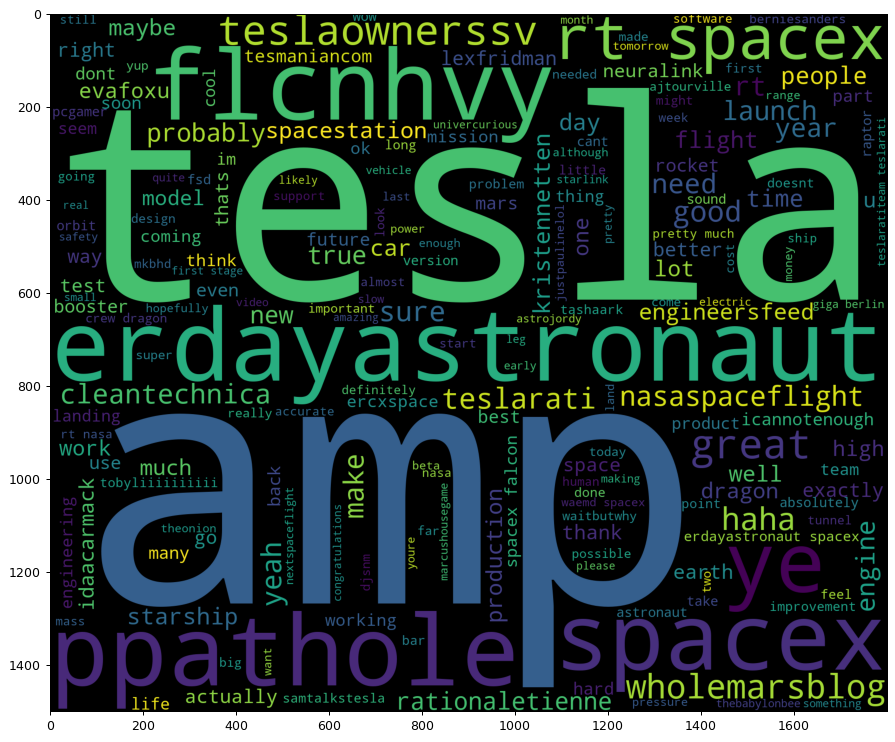

In [51]:
#wordcloud for entire corpus
from wordcloud import WordCloud
plt.figure(figsize=(12,12),dpi=90)
wordcloud_stw = WordCloud(background_color= 'black', width = 1800, height = 1500).generate(string_Total)
plt.imshow(wordcloud_stw);

In [53]:
pip install textblob


     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     --------- ------------------------------ 10.2/42.0 kB ? eta -:--:--
     -------------------------------------- 42.0/42.0 kB 511.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ----- ---------------------------------- 92.2/626.3 kB 2.6 MB/s eta 0:00:01
   ------------- -------------------------- 204.8/626.3 kB 3.1 MB/s eta 0:00:01
   -------------------- ------------------- 317.4/626.3 kB 3.3 MB/s eta 0:00:01
   ---------------------------- ----------- 450.6/626.3 kB 3.1 MB/s eta 0:00:01
   ------------------------------------- -- 583.7/626.3 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.5 MB 5.9 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.5 MB 5.9 MB/s eta 0:00:01
   -

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataprep 0.4.1 requires regex<2021.0.0,>=2020.10.15, but you have regex 2023.12.25 which is incompatible.


In [54]:
from textblob import TextBlob

# Get The Subjectivity
def sentiment_analysis(ds):
    sentiment = TextBlob(ds["Text"]).sentiment
    return pd.Series([sentiment.subjectivity, sentiment.polarity])

# Adding Subjectivity & Polarity
tweets[["subjectivity", "polarity"]] = tweets.apply(sentiment_analysis, axis=1)
tweets.head(11)

,Text,subjectivity,polarity
0,im alien,0.750000,-0.250000
1,idaacarmack ray tracing cyberpunk hdr nextleve...,0.000000,0.000000
2,joerogan spotify great interview,0.750000,0.800000
3,doge underestimated,0.000000,0.000000
4,teslacn congratulations tesla china amazing ex...,0.322222,0.200000
5,happy new year ox,0.727273,0.468182
6,frodo underdoge thought would fail httpstcozgx...,0.300000,-0.500000
7,owensparks flcnhvy haha thanks,0.250000,0.200000
8,flcnhvy indeed tweets definitely represent rea...,0.500000,0.000000
9,entertaining outcome likely,0.850000,0.250000


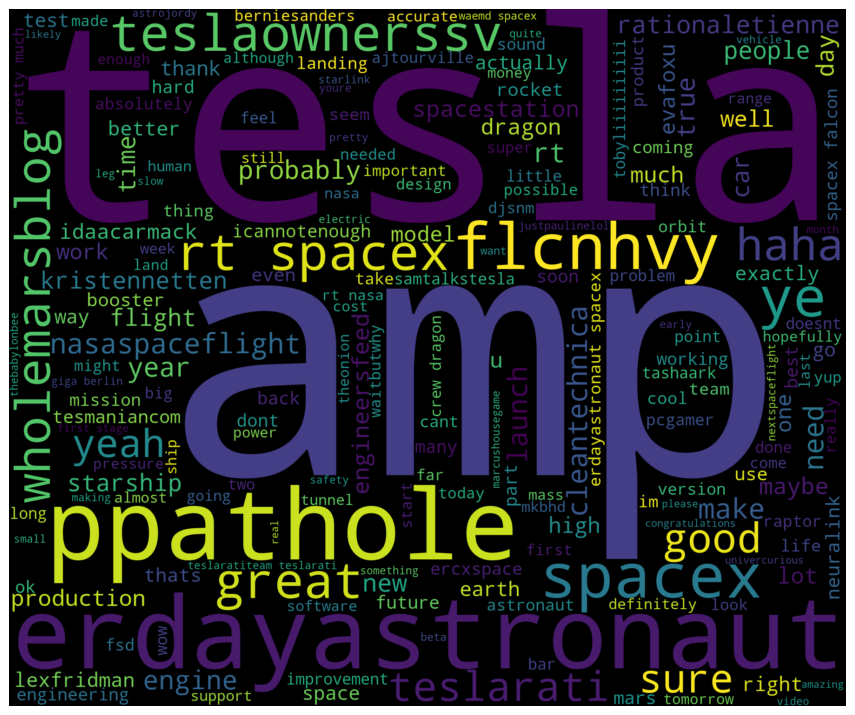

In [55]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

allwords = " ".join([twts for twts in tweets["Text"]])
wordCloud = WordCloud(width = 1800, height = 1500, random_state = 21).generate(allwords)
plt.figure(figsize=(12,12), dpi=90)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [61]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [62]:

def analysis(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

tweets["analysis"] = tweets["polarity"].apply(analysis)

In [63]:
positive_tweets = tweets[tweets['analysis'] == 'Positive']
negative_tweets = tweets[tweets['analysis'] == 'Negative']

print('positive tweets')
for i, row in positive_tweets[:5].iterrows():
    print(' -' + row['Text'])

print('negative tweets')
for i, row in negative_tweets[:5].iterrows():
    print(' -' + row['Text'])

positive tweets
 -joerogan spotify great interview
 -teslacn congratulations tesla china amazing execution last year next even
 -happy new year ox
 -owensparks flcnhvy haha thanks
 -entertaining outcome likely
negative tweets
 -im alien
 -frodo underdoge thought would fail httpstcozgxjfdzzrm
 -freewalletorg app sucks
 -rationaletienne adamklotz starlink staggeringly difficult technical amp economic endeavor however
 -rationaletienne adamklotz spacex needs pass deep chasm negative cash flow next year


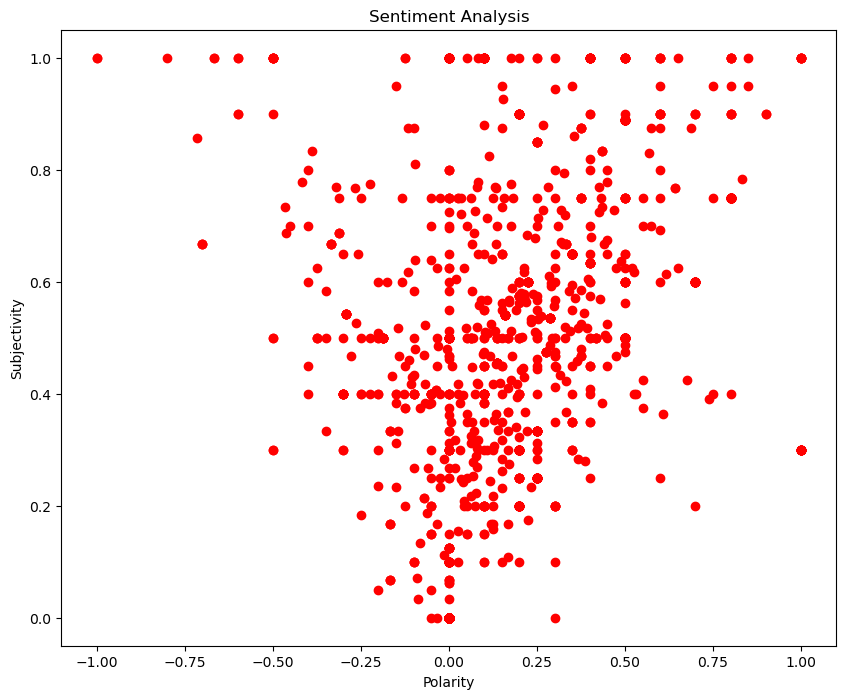

In [64]:
plt.figure(figsize=(10, 8))

for i in range(0, tweets.shape[0]):
    plt.scatter(tweets["polarity"][i], tweets["subjectivity"][i], color = "Red")

plt.title("Sentiment Analysis") # Add The Graph Title
plt.xlabel("Polarity") # Add The X-Label
plt.ylabel("Subjectivity") # Add The Y-Label
plt.show() # Showing The Graph

In [60]:
(len(positive_tweets) / len(negative_tweets))*100

422.11055276381904